In [1]:
DATA_CSV = "../results/attractor_states.csv"

GENERATE_DATA = False
# Parameters for generating data
MODEL_DIRECTORY = "../models/random_nk3"
UPDATE = "asynchronous"
N_RANDOM = 30 # number of random models
DEBUG = False
NSQUARE_STEPS = 20 # number of steps for nsquare

# Figure configuration
SUP_FIGURE_ID = "s1"
METRICS = ["precision", "specificity"]
METHODS = ["sd_mc", "ref"]
FIGURE_DIR = "../results/figures"

In [2]:
import pandas as pd
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg
from pyboolnet.trap_spaces import compute_trap_spaces
from IPython.display import display

import sdmarkov.plotting.config as pc
from sdmarkov.transition_matrix import get_transition_matrix, get_uniform_matrix
from sdmarkov.scc_dags import get_scc_dag, get_attractor_states
from sdmarkov.matrix_operations import nsquare, compress_matrix, expand_matrix, get_confusion_matrix
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.attractors import attractor_or_transient
from sdmarkov.analysis.utils import load_or_generate_data, add_classification_metrics, network_level_metrics_df
from sdmarkov.plotting.figures import plot_violin_figure, plot_distribution_figure, save_figure

In [3]:
def get_data_attractor_states(
    bnet,
    bnet_name=None,
    update="asynchronous",
    num_runs=30,
    DEBUG=False,
):
    """
    Compute attractor-vs-transient classification accuracy for
    SD, null, uniform, and random groupings.

    Returns
    -------
    pd.DataFrame
        Long-format table with columns:
        bnet, method, run, TP, FP, TN, FN,
        n_states, n_attractors, n_min_trap
    """

    rows = []

    primes = bnet_text2primes(bnet)
    primes = {k: primes[k] for k in sorted(primes)}

    # Percolate constants
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return pd.DataFrame(rows)

    percolated_bnet = primes2bnet(percolated_primes)
    n_states = 2 ** len(percolated_primes)

    # --- attractor metadata ---
    stg = primes2stg(percolated_primes, update)
    scc_dag = get_scc_dag(stg)
    attractor_indices = get_attractor_states(scc_dag, as_indices=True, DEBUG=DEBUG)
    n_attractors = len(attractor_indices)

    min_trap = compute_trap_spaces(percolated_primes, type_="min")
    n_min_trap = len(min_trap)

    # --- full transition matrix ---
    T = get_transition_matrix(stg, DEBUG=DEBUG)

    # --- grouped matrices ---
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)

    # Actual attractor matrix
    T_inf = nsquare(T, 20, DEBUG=DEBUG)
    attractor_states = attractor_or_transient(T_inf, DEBUG=DEBUG)

    # Uniform reference
    Tuniform = get_uniform_matrix(n_states)
    ref_attr = attractor_or_transient(Tuniform, DEBUG=DEBUG)

    # --- helper: grouped attractor matrix ---
    def grouped_attractor_matrix(T_grouped, indices, DEBUG=False):
        T_inf = nsquare(T_grouped, 20, DEBUG=DEBUG)
        T_inf_expanded = expand_matrix(T_inf, indices, DEBUG=DEBUG)
        return attractor_or_transient(T_inf_expanded, DEBUG=DEBUG)

    sd_attr = grouped_attractor_matrix(Tsd, sd_indices, DEBUG=DEBUG)
    null_attr = grouped_attractor_matrix(Tnull, null_indices, DEBUG=DEBUG)

    # --- helper: add row ---
    def add_row(method, predictions, run=None):
        TP, FP, TN, FN = get_confusion_matrix(
            attractor_states, predictions, partial=True, DEBUG=DEBUG
        )
        rows.append({
            "bnet": bnet_name,
            "method": method,
            "run": run,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "n_states": n_states,
            "n_attractors": n_attractors,
            "n_min_trap": n_min_trap,
        })

    # --- deterministic methods ---
    add_row("sd_mc", sd_attr)
    add_row("null_mc", null_attr)
    add_row("ref", ref_attr)

    # --- random baseline ---
    for i in range(num_runs):
        random_indices = random_grouping(
            sd_indices, null_indices, seed=i, DEBUG=DEBUG
        )
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        random_attr = grouped_attractor_matrix(
            Trandom, random_indices, DEBUG=DEBUG
        )
        add_row("random_mc", random_attr, run=i)

    return pd.DataFrame(rows)


In [4]:
df = load_or_generate_data(
    data_csv=DATA_CSV,
    generate_data=GENERATE_DATA,
    data_function=get_data_attractor_states,
    model_directory=MODEL_DIRECTORY,
    update=UPDATE,
    n_random=N_RANDOM,
    debug=DEBUG,
)

Loaded cached results from ../results/attractor_states.csv.


In [5]:
print("Preview of results DataFrame:")
display(df.head())

print("\nDataFrame shape:", df.shape)
print("Methods present:", df.method.unique())

Preview of results DataFrame:


,bnet,method,run,TP,FP,TN,FN,n_states,n_attractors,n_min_trap,update_scheme
0,n010_000.bnet,sd_mc,NaN,56,8,960,0,1024,2,2,asynchronous
1,n010_000.bnet,null_mc,NaN,56,8,960,0,1024,2,2,asynchronous
2,n010_000.bnet,ref,NaN,56,968,0,0,1024,2,2,asynchronous
3,n010_000.bnet,random_mc,0.0,56,8,960,0,1024,2,2,asynchronous
4,n010_000.bnet,random_mc,1.0,56,8,960,0,1024,2,2,asynchronous



DataFrame shape: (3003, 11)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']


## Data analysis

In [6]:
# add precision, recall, specificity, and NPV
df = add_classification_metrics(df)

print("\nAdded classification metrics")
print("DataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

display(df.head())


Added classification metrics
DataFrame shape: (3003, 15)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 91


,bnet,method,run,TP,FP,TN,FN,n_states,n_attractors,n_min_trap,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,sd_mc,NaN,56,8,960,0,1024,2,2,asynchronous,0.875000,1.0,0.991736,1.0
1,n010_000.bnet,null_mc,NaN,56,8,960,0,1024,2,2,asynchronous,0.875000,1.0,0.991736,1.0
2,n010_000.bnet,ref,NaN,56,968,0,0,1024,2,2,asynchronous,0.054688,1.0,0.000000,NaN
3,n010_000.bnet,random_mc,0.0,56,8,960,0,1024,2,2,asynchronous,0.875000,1.0,0.991736,1.0
4,n010_000.bnet,random_mc,1.0,56,8,960,0,1024,2,2,asynchronous,0.875000,1.0,0.991736,1.0


In [7]:
df_metrics = network_level_metrics_df(df=df)

print("Preview of network-level metrics DataFrame:")
display(df_metrics.head())

print("\nDataFrame shape:", df_metrics.shape)
print("Methods present:", df_metrics.method.unique())
print("Number of unique networks:", df_metrics.bnet.nunique())

print("\nNetwork-level classification metrics:")
metrics = ["precision", "recall", "specificity", "npv"]
summary = (
    df_metrics
    .groupby("method")[metrics]
    .agg(["mean", "min", "median", "max"])
)

display(summary)

Preview of network-level metrics DataFrame:


,bnet,method,TP,FP,TN,FN,n_states,n_attractors,n_min_trap,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,null_mc,56.0,8.0,960.0,0.0,1024.0,2.0,2.0,asynchronous,0.875000,1.0,0.991736,1.0
1,n010_000.bnet,random_mc,56.0,8.0,960.0,0.0,1024.0,2.0,2.0,asynchronous,0.875000,1.0,0.991736,1.0
2,n010_000.bnet,ref,56.0,968.0,0.0,0.0,1024.0,2.0,2.0,asynchronous,0.054688,1.0,0.000000,NaN
3,n010_000.bnet,sd_mc,56.0,8.0,960.0,0.0,1024.0,2.0,2.0,asynchronous,0.875000,1.0,0.991736,1.0
4,n010_001.bnet,null_mc,6.0,0.0,58.0,0.0,64.0,5.0,5.0,asynchronous,1.000000,1.0,1.000000,1.0



DataFrame shape: (364, 14)
Methods present: ['null_mc' 'random_mc' 'ref' 'sd_mc']
Number of unique networks: 91

Network-level classification metrics:


precision                         recall                   \
               mean       min   median  max   mean  min median  max   
method                                                                
null_mc    0.971509  0.625000  1.00000  1.0    1.0  1.0    1.0  1.0   
random_mc  0.971509  0.625000  1.00000  1.0    1.0  1.0    1.0  1.0   
ref        0.219190  0.000977  0.03125  1.0    1.0  1.0    1.0  1.0   
sd_mc      0.971509  0.625000  1.00000  1.0    1.0  1.0    1.0  1.0   

          specificity                   npv                   
                 mean  min median  max mean  min median  max  
method                                                        
null_mc      0.933807  0.0    1.0  1.0  1.0  1.0    1.0  1.0  
random_mc    0.933807  0.0    1.0  1.0  1.0  1.0    1.0  1.0  
ref          0.000000  0.0    0.0  0.0  NaN  NaN    NaN  NaN  
sd_mc        0.933807  0.0    1.0  1.0  1.0  1.0    1.0  1.0

## Plotting

In [8]:
pc.apply_style()

/home/troonmel/SDMarkov/sdmarkov/src/sdmarkov/plotting/figures.py:176: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


PosixPath('../results/figures/Figure_s1_Attractor_states.png')

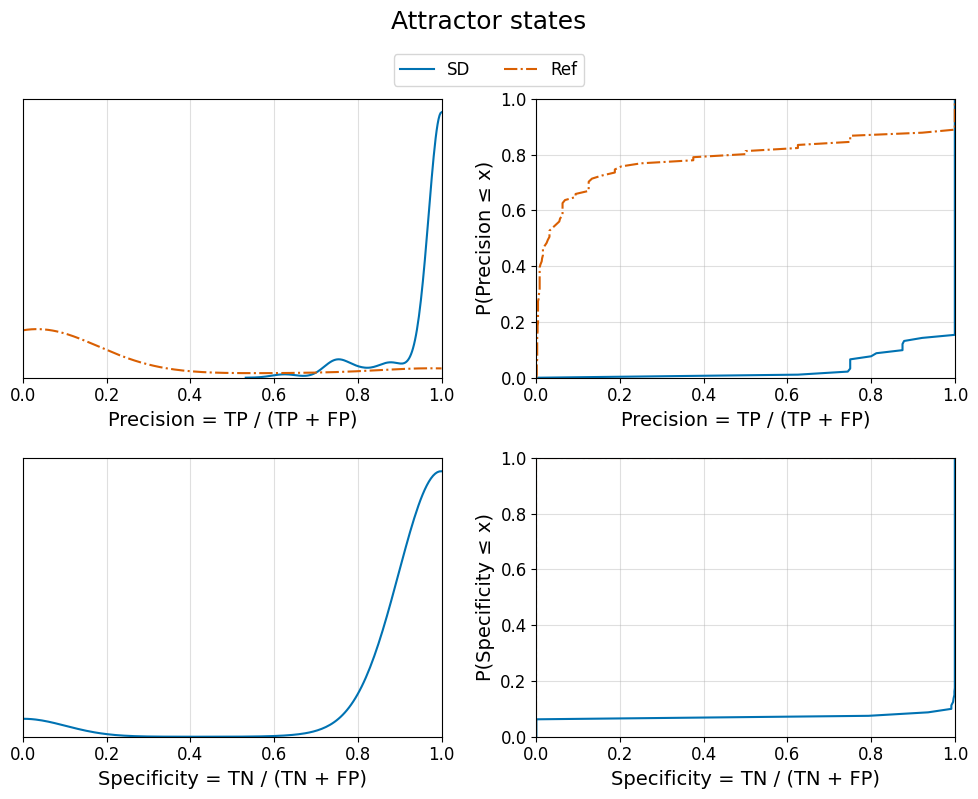

In [10]:
fig = plot_distribution_figure(df_metrics, metrics=METRICS, methods=METHODS, figure_id=SUP_FIGURE_ID)

save_figure(fig, figure_id=SUP_FIGURE_ID, outdir=FIGURE_DIR)